# Task 1

Epoch 500/5000, Loss: 0.217052
Epoch 1000/5000, Loss: 0.009548
Epoch 1000/5000, Loss: 0.009548
Epoch 1500/5000, Loss: 0.000532
Epoch 1500/5000, Loss: 0.000532
Epoch 2000/5000, Loss: 0.000127
Epoch 2000/5000, Loss: 0.000127
Epoch 2500/5000, Loss: 0.000076
Epoch 2500/5000, Loss: 0.000076
Epoch 3000/5000, Loss: 0.000038
Epoch 3000/5000, Loss: 0.000038
Epoch 3500/5000, Loss: 0.000024
Epoch 3500/5000, Loss: 0.000024
Epoch 4000/5000, Loss: 0.000018
Epoch 4000/5000, Loss: 0.000018
Epoch 4500/5000, Loss: 0.000013
Epoch 4500/5000, Loss: 0.000013
Epoch 5000/5000, Loss: 0.000011
Epoch 5000/5000, Loss: 0.000011


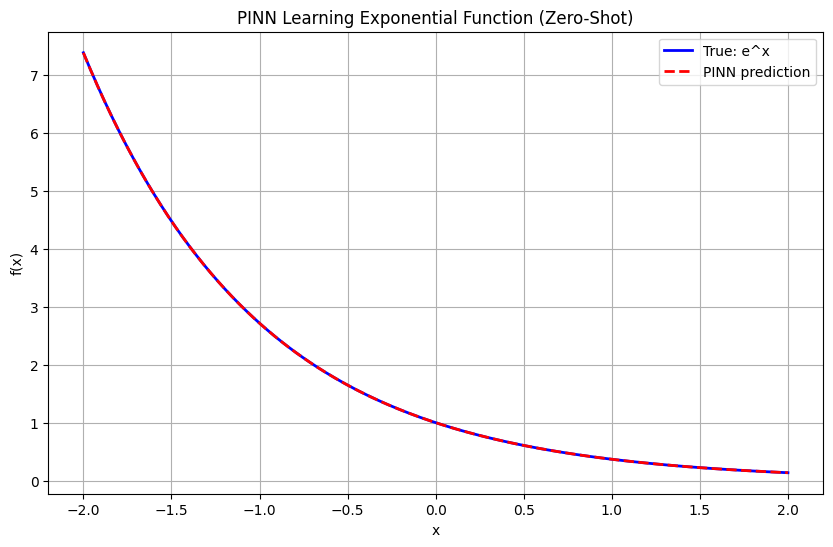


Mean Absolute Error: 0.000453


In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# Physics loss: f'(x) = -f(x), where f(x) = e^-x
def physics_loss(model, x):
    x.requires_grad_(True)
    f = model(x)
    df_dx = torch.autograd.grad(f, x, torch.ones_like(f), create_graph=True)[0]
    return torch.mean((df_dx + f)**2)

# Initial condition loss: f(0) = 1
def initial_condition_loss(model):
    x0 = torch.tensor([[0.0]], requires_grad=True)
    f0 = model(x0)
    return (f0 - 1.0)**2

# Training
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training points (collocation points)
x_train = torch.linspace(-2, 2, 100).reshape(-1, 1)

# Train the PINN
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute losses
    phys_loss = physics_loss(model, x_train)
    ic_loss = initial_condition_loss(model)
    
    # Total loss
    loss = phys_loss + ic_loss
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

# Test the model
x_test = torch.linspace(-2, 2, 200).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(x_test).numpy()

# True exponential function
y_true = np.exp(-x_test.numpy())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), y_true, 'b-', label='True: e^x', linewidth=2)
plt.plot(x_test.numpy(), y_pred, 'r--', label='PINN prediction', linewidth=2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('PINN Learning Exponential Function (Zero-Shot)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate error
error = np.mean(np.abs(y_pred - y_true))
print(f'\nMean Absolute Error: {error:.6f}')

# Task 2

Training PINN (tanh)...
Epoch 1000, Loss: 0.006819
Epoch 1000, Loss: 0.006819
Epoch 2000, Loss: 0.004306
Epoch 2000, Loss: 0.004306
Epoch 3000, Loss: 0.003338
Epoch 3000, Loss: 0.003338
Epoch 4000, Loss: 0.003094
Epoch 4000, Loss: 0.003094
Epoch 5000, Loss: 0.002997

Training PINN (sigmoid)...
Epoch 5000, Loss: 0.002997

Training PINN (sigmoid)...
Epoch 1000, Loss: 0.019853
Epoch 1000, Loss: 0.019853
Epoch 2000, Loss: 0.007823
Epoch 2000, Loss: 0.007823
Epoch 3000, Loss: 0.006524
Epoch 3000, Loss: 0.006524
Epoch 4000, Loss: 0.006153
Epoch 4000, Loss: 0.006153
Epoch 5000, Loss: 0.005945

Training Regular NN...
Epoch 5000, Loss: 0.005945

Training Regular NN...
Epoch 1000, Loss: 0.000000
Epoch 1000, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 3000, Loss: 0.000000
Epoch 3000, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 5000, Loss: 0.000000
Epoch 5000, Loss: 0.000000


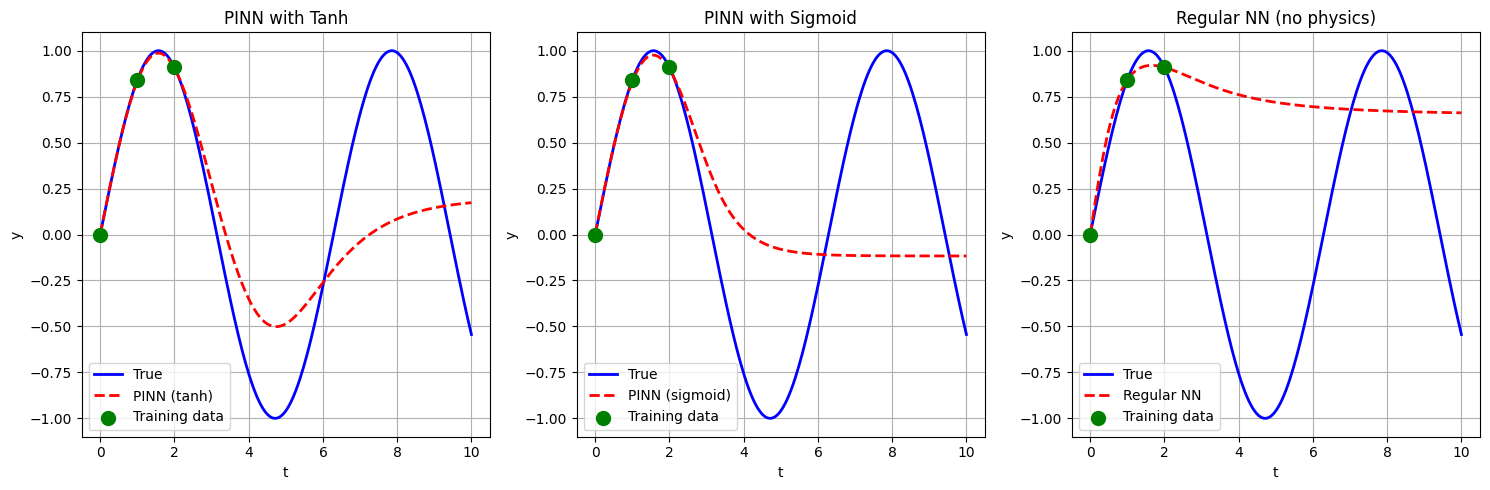


Mean Absolute Errors:
PINN (tanh):    0.327117
PINN (sigmoid): 0.458065
Regular NN:     0.620711


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate training data (only 3 points)
t_data = torch.tensor([[0.0], [1.0], [2.0]])
y_data = torch.sin(t_data)

# Full test data
t_test = torch.linspace(0, 10, 200).reshape(-1, 1)
y_true = np.sin(t_test.numpy())

# Neural Network
class Net(nn.Module):
    def __init__(self, activation='tanh'):
        super(Net, self).__init__()
        act = nn.Tanh() if activation == 'tanh' else nn.Sigmoid()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            act,
            nn.Linear(20, 20),
            act,
            nn.Linear(20, 1)
        )
    
    def forward(self, t):
        return self.net(t)

# Physics loss for SHM: y'' + y = 0
def physics_loss(model, t):
    t = t.clone().detach().requires_grad_(True)
    y = model(t)
    dy_dt = torch.autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, t, torch.ones_like(dy_dt), create_graph=True)[0]
    return torch.mean((d2y_dt2 + y)**2)

# Data loss
def data_loss(model, t, y):
    y_pred = model(t)
    return torch.mean((y_pred - y)**2)

# Train PINN with tanh
print("Training PINN (tanh)...")
pinn_tanh = Net(activation='tanh')
optimizer = torch.optim.Adam(pinn_tanh.parameters(), lr=0.001)

for epoch in range(5000):
    optimizer.zero_grad()
    d_loss = data_loss(pinn_tanh, t_data, y_data)
    p_loss = physics_loss(pinn_tanh, torch.linspace(0, 10, 50).reshape(-1, 1))
    loss = d_loss + 0.1 * p_loss
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

# Train PINN with sigmoid
print("\nTraining PINN (sigmoid)...")
pinn_sigmoid = Net(activation='sigmoid')
optimizer = torch.optim.Adam(pinn_sigmoid.parameters(), lr=0.001)

for epoch in range(5000):
    optimizer.zero_grad()
    d_loss = data_loss(pinn_sigmoid, t_data, y_data)
    p_loss = physics_loss(pinn_sigmoid, torch.linspace(0, 10, 50).reshape(-1, 1))
    loss = d_loss + 0.1 * p_loss
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

# Train regular NN (no physics)
print("\nTraining Regular NN...")
regular_nn = Net(activation='tanh')
optimizer = torch.optim.Adam(regular_nn.parameters(), lr=0.001)

for epoch in range(5000):
    optimizer.zero_grad()
    loss = data_loss(regular_nn, t_data, y_data)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

# Test all models
with torch.no_grad():
    y_pinn_tanh = pinn_tanh(t_test).numpy()
    y_pinn_sigmoid = pinn_sigmoid(t_test).numpy()
    y_regular = regular_nn(t_test).numpy()

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(t_test.numpy(), y_true, 'b-', label='True', linewidth=2)
plt.plot(t_test.numpy(), y_pinn_tanh, 'r--', label='PINN (tanh)', linewidth=2)
plt.scatter(t_data.numpy(), y_data.numpy(), color='green', s=100, label='Training data', zorder=5)
plt.xlabel('t')
plt.ylabel('y')
plt.title('PINN with Tanh')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(t_test.numpy(), y_true, 'b-', label='True', linewidth=2)
plt.plot(t_test.numpy(), y_pinn_sigmoid, 'r--', label='PINN (sigmoid)', linewidth=2)
plt.scatter(t_data.numpy(), y_data.numpy(), color='green', s=100, label='Training data', zorder=5)
plt.xlabel('t')
plt.ylabel('y')
plt.title('PINN with Sigmoid')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(t_test.numpy(), y_true, 'b-', label='True', linewidth=2)
plt.plot(t_test.numpy(), y_regular, 'r--', label='Regular NN', linewidth=2)
plt.scatter(t_data.numpy(), y_data.numpy(), color='green', s=100, label='Training data', zorder=5)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Regular NN (no physics)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate errors
error_pinn_tanh = np.mean(np.abs(y_pinn_tanh - y_true))
error_pinn_sigmoid = np.mean(np.abs(y_pinn_sigmoid - y_true))
error_regular = np.mean(np.abs(y_regular - y_true))

print(f'\nMean Absolute Errors:')
print(f'PINN (tanh):    {error_pinn_tanh:.6f}')
print(f'PINN (sigmoid): {error_pinn_sigmoid:.6f}')
print(f'Regular NN:     {error_regular:.6f}')
